In [1]:
from cohirf.experiment.hpo_classification_clustering_experiment import HPOClassificationClusteringExperiment
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from IPython.display import clear_output

In [2]:
def plot_results(results, time="hpo_time", log_time=False):
    results = results.copy()
    x_axis_label = "Standard Deviation of Non Informative Features"
    y_axis_label_metric = "Adjusted Rand Index (ARI)"
    y_axis_label_time = "Time (s)"
    results.rename(columns={"std_random": x_axis_label, "ari": y_axis_label_metric, time: y_axis_label_time, 'model': 'Model'}, inplace=True)
    plt.style.use("seaborn-v0_8-whitegrid")
    with mpl.rc_context(
        rc={
            "figure.constrained_layout.use": True,
            "savefig.bbox": "tight",
            "figure.figsize": (12, 7),
            "legend.loc": "upper left",
            "legend.frameon": True,
            "font.size": 14,
            "axes.titlesize": 16,
            "axes.labelsize": 15,
            "xtick.labelsize": 13,
            "ytick.labelsize": 13,
            "axes.grid": True,
            "grid.color": "grey",
            "grid.alpha": 0.3,
        }
    ):
        fig, axs = plt.subplots(2, 1, sharex=True)
        axs = axs.flatten()
        palette = sns.color_palette("tab10", n_colors=len(results["Model"].unique()))
        # Time plot
        ax = sns.lineplot(
            data=results,
            x=x_axis_label,
            y=y_axis_label_time,
            hue="Model",
            style="Model",
            markers=True,
            dashes=False,
            errorbar="ci",
            ax=axs[0],
            palette=palette,
        )
        if log_time:
            ax.set_yscale("log")
        ax.set_ylabel(y_axis_label_time)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        # ARI plot
        ax2 = sns.lineplot(
            data=results,
            x=x_axis_label,
            y=y_axis_label_metric,
            hue="Model",
            style="Model",
            markers=True,
            dashes=False,
            errorbar="ci",
            ax=axs[1],
            palette=palette,
        )
        ax2.set_ylabel(y_axis_label_metric)
        ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
        # Remove duplicate legends
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
        ax.get_legend().remove()
        ax2.get_legend().remove()
        plt.xlabel(x_axis_label)
        plt.tight_layout()
        plt.show()
        return fig, axs

In [3]:
results_dir = Path("/home/belucci/code/cohirf/results") / "features_non_informatives_std"
results_dir.mkdir(parents=True, exist_ok=True)
mlflow_tracking_uri = f"sqlite:///{results_dir}/mlflow.db"
experiment_params = dict(
    mlflow_tracking_uri=mlflow_tracking_uri,
    check_if_exists=False,
	verbose=1,
)

In [ ]:
n_informative = 3
dataset_params = dict(
    n_samples=1000,
    n_random=1000,
    n_classes=5,
    n_informative=n_informative,
    n_redundant=0,
    n_repeated=0,
    n_clusters_per_class=1,
    weights=None,
    flip_y=0.0,
    class_sep=3 * (n_informative**0.5),
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=True,
    n_features_dataset=None,
    pct_random=None,
)

In [5]:
all_results = pd.DataFrame()

# KMeans

In [27]:
seed = 0
seeds = [i for i in range(1)]
std_random = [1.01, 1.02, 1.03]
combinations = list(product(seeds, std_random))
model = "KMeans"
results = []
for seed, std_random in combinations:
    print(f"Running combination: seed={seed}, std_random={std_random}")
    experiment = HPOClassificationClusteringExperiment(
        # hpo
        n_trials=30,
        hpo_seed=seed,
        hpo_metric="adjusted_rand",
        direction="maximize",
        # model
        experiment_name="kmeans",
        model=model,
        seed_model=seed,
        # dataset
        seed_dataset=seed,
        std_random=std_random,
        **dataset_params,
        **experiment_params,
    )
    result = experiment.run(return_results=True)[0]
    ari = result["evaluate_model_return"]["best/adjusted_rand"]
    hpo_time = result["fit_model_return"]["elapsed_time"]
    best_time = result["evaluate_model_return"]["best/elapsed_time"]
    results.append(dict(ari=ari, hpo_time=hpo_time, best_time=best_time, seed=seed, std_random=std_random, model=model))
    clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running combination: seed=0, std_random=1.03


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

In [34]:
all_results

,ari,hpo_time,best_time,seed,std_random,model
0,1.000000,15.472968,0.122527,0,1.00,KMeans
1,0.006068,15.014719,0.124167,0,2.00,KMeans
2,0.005469,14.549581,0.126675,0,5.00,KMeans
3,0.009574,15.022685,0.123410,0,1.10,KMeans
4,0.010892,15.141447,0.117864,0,1.20,KMeans
5,0.009828,14.652127,0.119267,0,1.30,KMeans
6,0.005710,15.957715,0.119927,0,1.01,KMeans
7,0.008816,16.181214,0.130731,0,1.02,KMeans
8,0.008008,15.098957,0.126569,0,1.03,KMeans


# CoHiRF

In [35]:
seed = 0
seeds = [i for i in range(1)]
std_random = [1.0, 2.0, 5.0, 1.1, 1.2, 1.3, 1.01, 1.02, 1.03]
combinations = list(product(seeds, std_random))
model = "CoHiRF"
results = []
for seed, std_random in combinations:
    print(f"Running combination: seed={seed}, std_random={std_random}")
    experiment = HPOClassificationClusteringExperiment(
        # hpo
        n_trials=30,
        hpo_seed=seed,
        hpo_metric="adjusted_rand",
        direction="maximize",
        # model
        experiment_name=model,
        model=model,
        seed_model=seed,
        # dataset
        seed_dataset=seed,
        std_random=std_random,
        **dataset_params,
        **experiment_params,
    )
    result = experiment.run(return_results=True)[0]
    ari = result["evaluate_model_return"]["best/adjusted_rand"]
    hpo_time = result["fit_model_return"]["elapsed_time"]
    best_time = result["evaluate_model_return"]["best/elapsed_time"]
    results.append(dict(ari=ari, hpo_time=hpo_time, best_time=best_time, seed=seed, std_random=std_random, model=model))
    clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running combination: seed=0, std_random=1.03


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/belucci/code/cohirf/cohirf/experiment/clustering_experiment.py:27: UserWarning: Too many clusters (1000) for dataset with 1000 samples. Skipping metric calculation. If you want to calculate metrics anyway, set `calculate_metrics_even_if_too_many_clusters` to True.
  warn(f"Too many clusters ({n_clusters}) for dataset with {X.shape[0]} samples. Skipping metric calculation. If you want to calculate metrics anyway, set `calculate_metrics_even_if_too_many_clusters` to True.")
/home/belucci/code/ml_experiments/ml_experiments/tuners.py:233: UserWarning: metric adjusted_rand not found in dict returned by training_fn, available metrics are dict_keys(['n_clusters_', 'elapsed_time', 'seed_model'])
  warn(f'metric {metric} not found in dict returned by training_fn, available metrics are '
/home/belucci/code/cohirf/cohirf/experiment/clustering_experiment.py:27: UserWarning: Too many clusters (944) for dataset with 1000 samples. Skipping metric calculation. If you want to calculate metrics an

In [37]:
all_results = pd.concat([all_results, results], ignore_index=True) 

/tmp/ipykernel_26845/1232421789.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


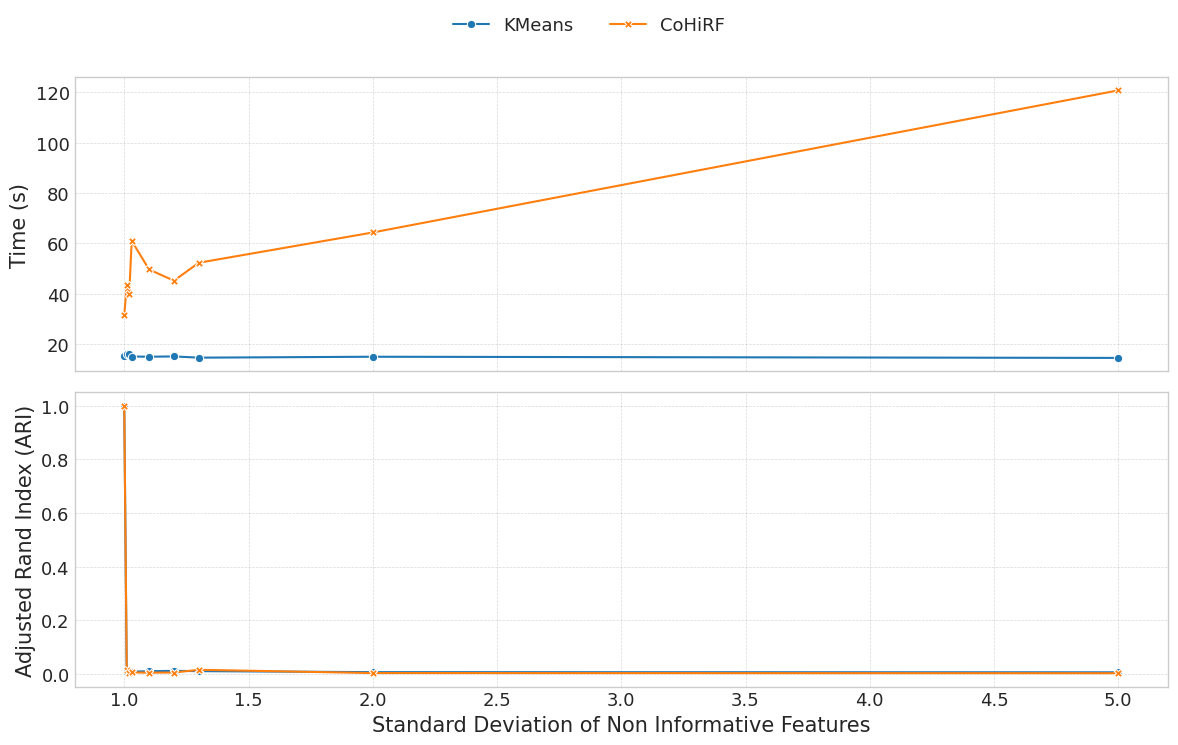

(<Figure size 1200x700 with 2 Axes>,
 array([<Axes: xlabel='Standard Deviation of Non Informative Features', ylabel='Time (s)'>,
        <Axes: xlabel='Standard Deviation of Non Informative Features', ylabel='Adjusted Rand Index (ARI)'>],
       dtype=object))

In [38]:
plot_results(all_results, time="hpo_time")